*Python Machine Learning 2nd Edition* by [Sebastian Raschka](https://sebastianraschka.com) and Vahid Mirjalili, Packt Publishing Ltd. 2017

Code Repository: https://github.com/rasbt/python-machine-learning-book-2nd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 16 - Modeling Sequential Data Using Recurrent Neural Networks



Note that the optional watermark extension is a small IPython notebook plugin that is being used to make the code reproducible. You can just skip the following line(s).

In [1]:
#load watermark
%load_ext watermark
%watermark -a 'Gopala KR' -u -d -v -p watermark,numpy,pandas,matplotlib,nltk,sklearn,tensorflow,theano,mxnet,chainer,seaborn,keras,tflearn,bokeh,gensim

/srv/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.
/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Gopala KR 
last updated: 2018-02-18 

CPython 3.6.3
IPython 6.2.1

watermark 1.6.0
numpy 1.14.0
pandas 0.22.0
matplotlib 2.1.2
nltk 3.2.5
sklearn 0.19.1
tensorflow 1.5.0
theano 1.0.1
mxnet 1.0.0
chainer 3.3.0
seaborn 0.8.1
keras 2.1.4
tflearn n
bokeh 0.12.14
gensim 3.3.0


/srv/venv/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

- [Introducing sequential data](#Introducing-sequential-data)
  - [Modeling sequential data: Order matters](#Modeling-sequential-data:-Order-matters)
  - [Understanding the different categories of sequence modeling](#Understanding-the-different-categories-of-sequence-modeling)
- [Recurrent neural networks for modeling sequences](#Recurrent-neural-networks-for-modeling-sequences)
  - [Understanding the structure and flow of a recurrent neural network 
](#Understanding-the-structure-and-flow-of-a-recurrent-neural-network)
  - [Computing activations in an RNN](#Computing-activations-in-an-RNN)
  - [The challenges of learning long-range interactions](#The-challenges-of-learning-long-range-interactions)
  - [Long short-term memory units](#Long-short-term-memory-units)
- [Implementing a multilayer RNN for sequence modeling in TensorFlow](#Implementing-a-multilayer-RNN-for-sequence-modeling-in-TensorFlow)
  - [Performing sentiment analysis of IMDb movie reviews using multilayer RNNs](#Performing-sentiment-analysis-of-IMDb-movie-reviews-using-multilayer-RNNs)
    - [Preparing the data](#Preparing-the-data)
    - [Embedding](#Embedding)
    - [Building the RNN model](#Building-the-RNN-model)
      - [Step 1: Defining multilayer RNN cells](#Step-1:-Defining-multilayer-RNN-cells)
      - [Step 2: Defining the initial states for the RNN cells](#Step-2:-Defining-the-initial-states-for-the-RNN-cells)
      - [Step 3: Creating the recurrent neural network using the RNN cells and their states](#Step-3:-Creating-the-recurrent-neural-network-using-the-RNN-cells-and-their-states)
  - [Example application: character-level language modeling](#Example-application:-character-level-language-modeling)
    - [Preparing the data](#Preparing-the-data)
    - [Building the character-level RNN model](#Building-the-character-level-RNN-model)
- [Summary](#Summary)

In [2]:
from IPython.display import Image

In [3]:
import gzip


with gzip.open('movie_data.csv.gz') as f_in, open('movie_data.csv', 'wb') as f_out:
    f_out.writelines(f_in)

# Introducing sequential data 

## Modeling sequential data: Order matters

## Representing sequences

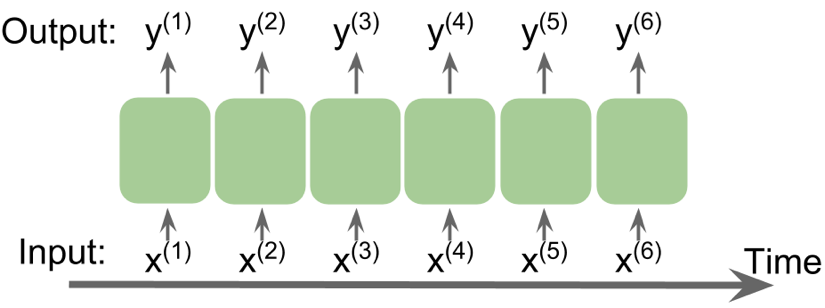

In [4]:
Image(filename='images/16_01.png', width=600) 

## Understanding the different categories of sequence modeling

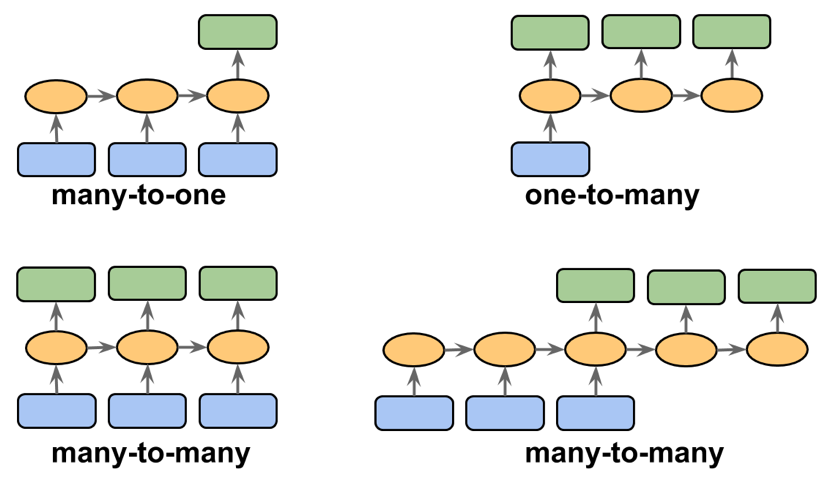

In [5]:
Image(filename='images/16_02.png', width=600) 

# Recurrent neural networks for modeling sequences

## Understanding the structure and flow of a recurrent neural network 

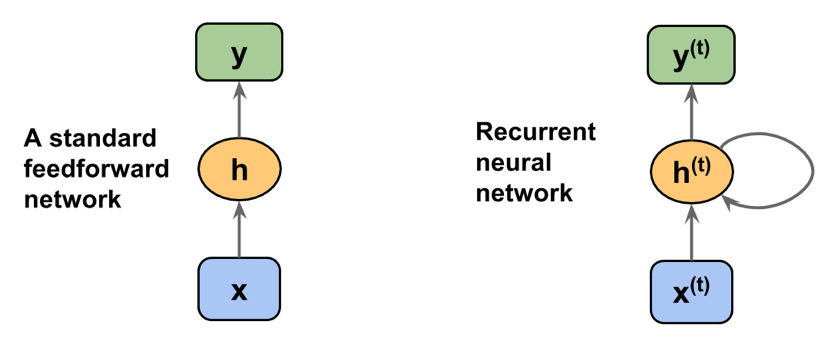

In [6]:
Image(filename='images/16_03.png', width=600) 

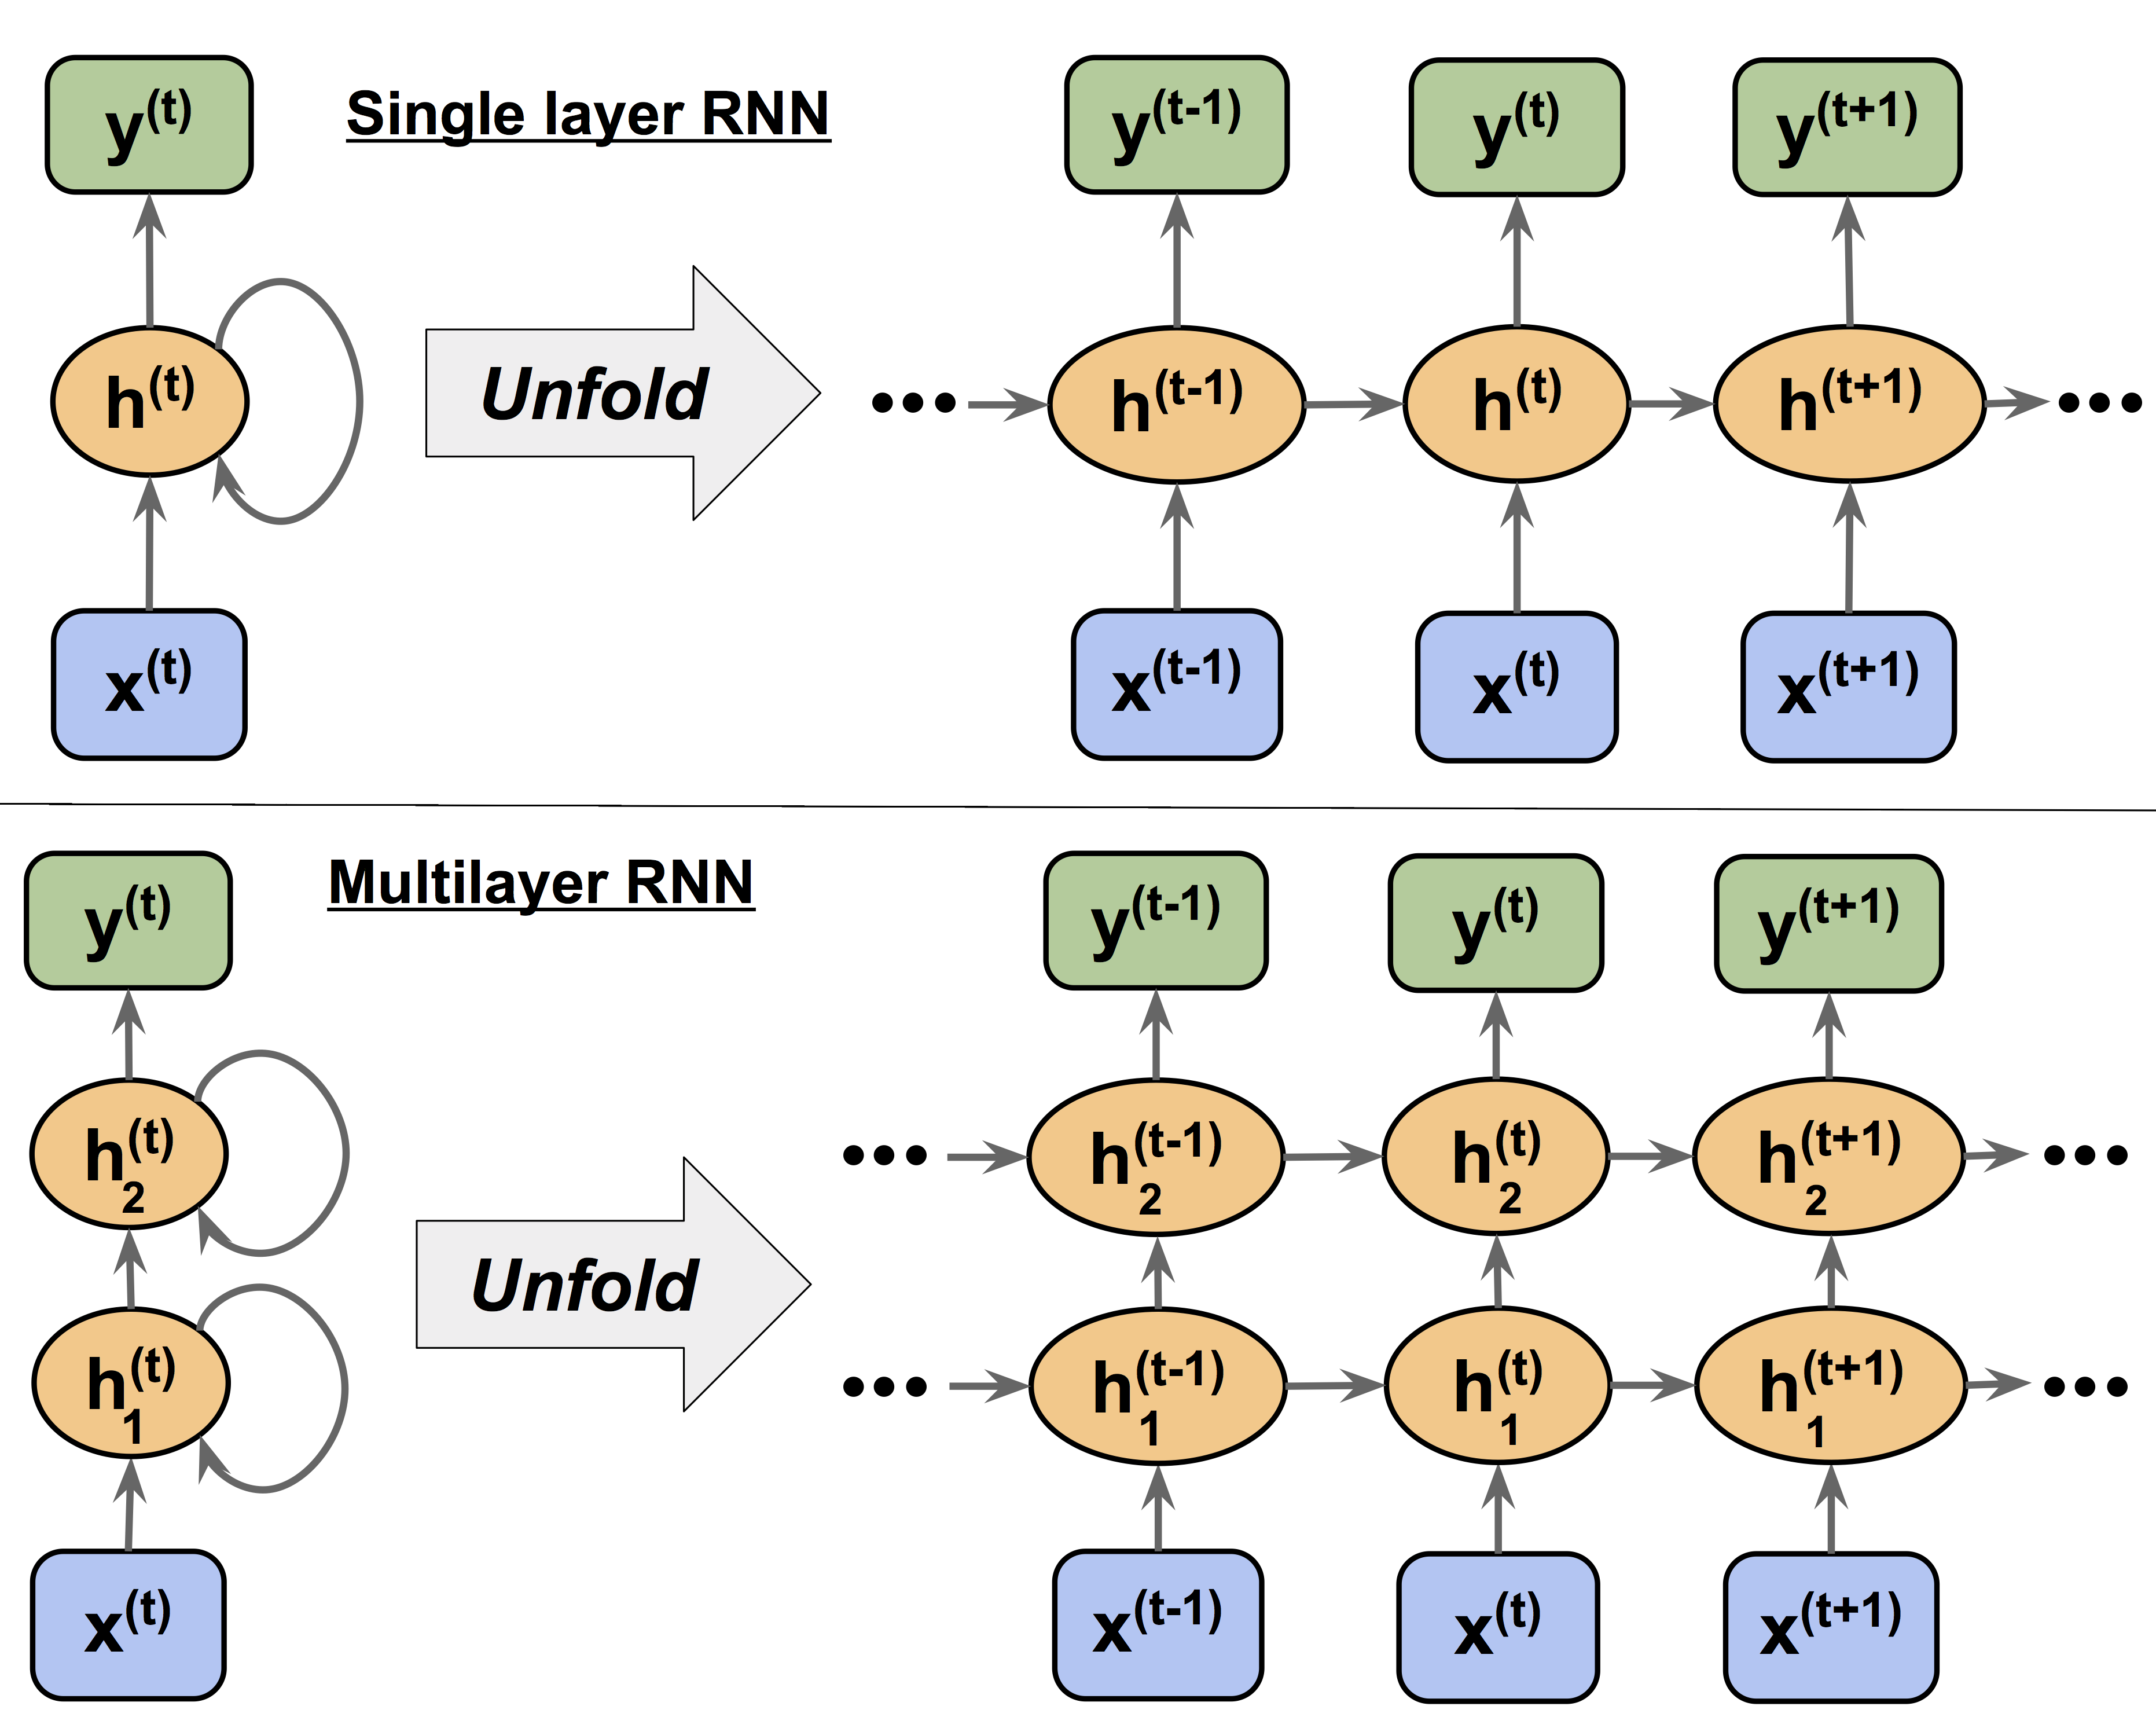

In [7]:
Image(filename='images/16_04.png', width=600) 

## Computing activations in an RNN

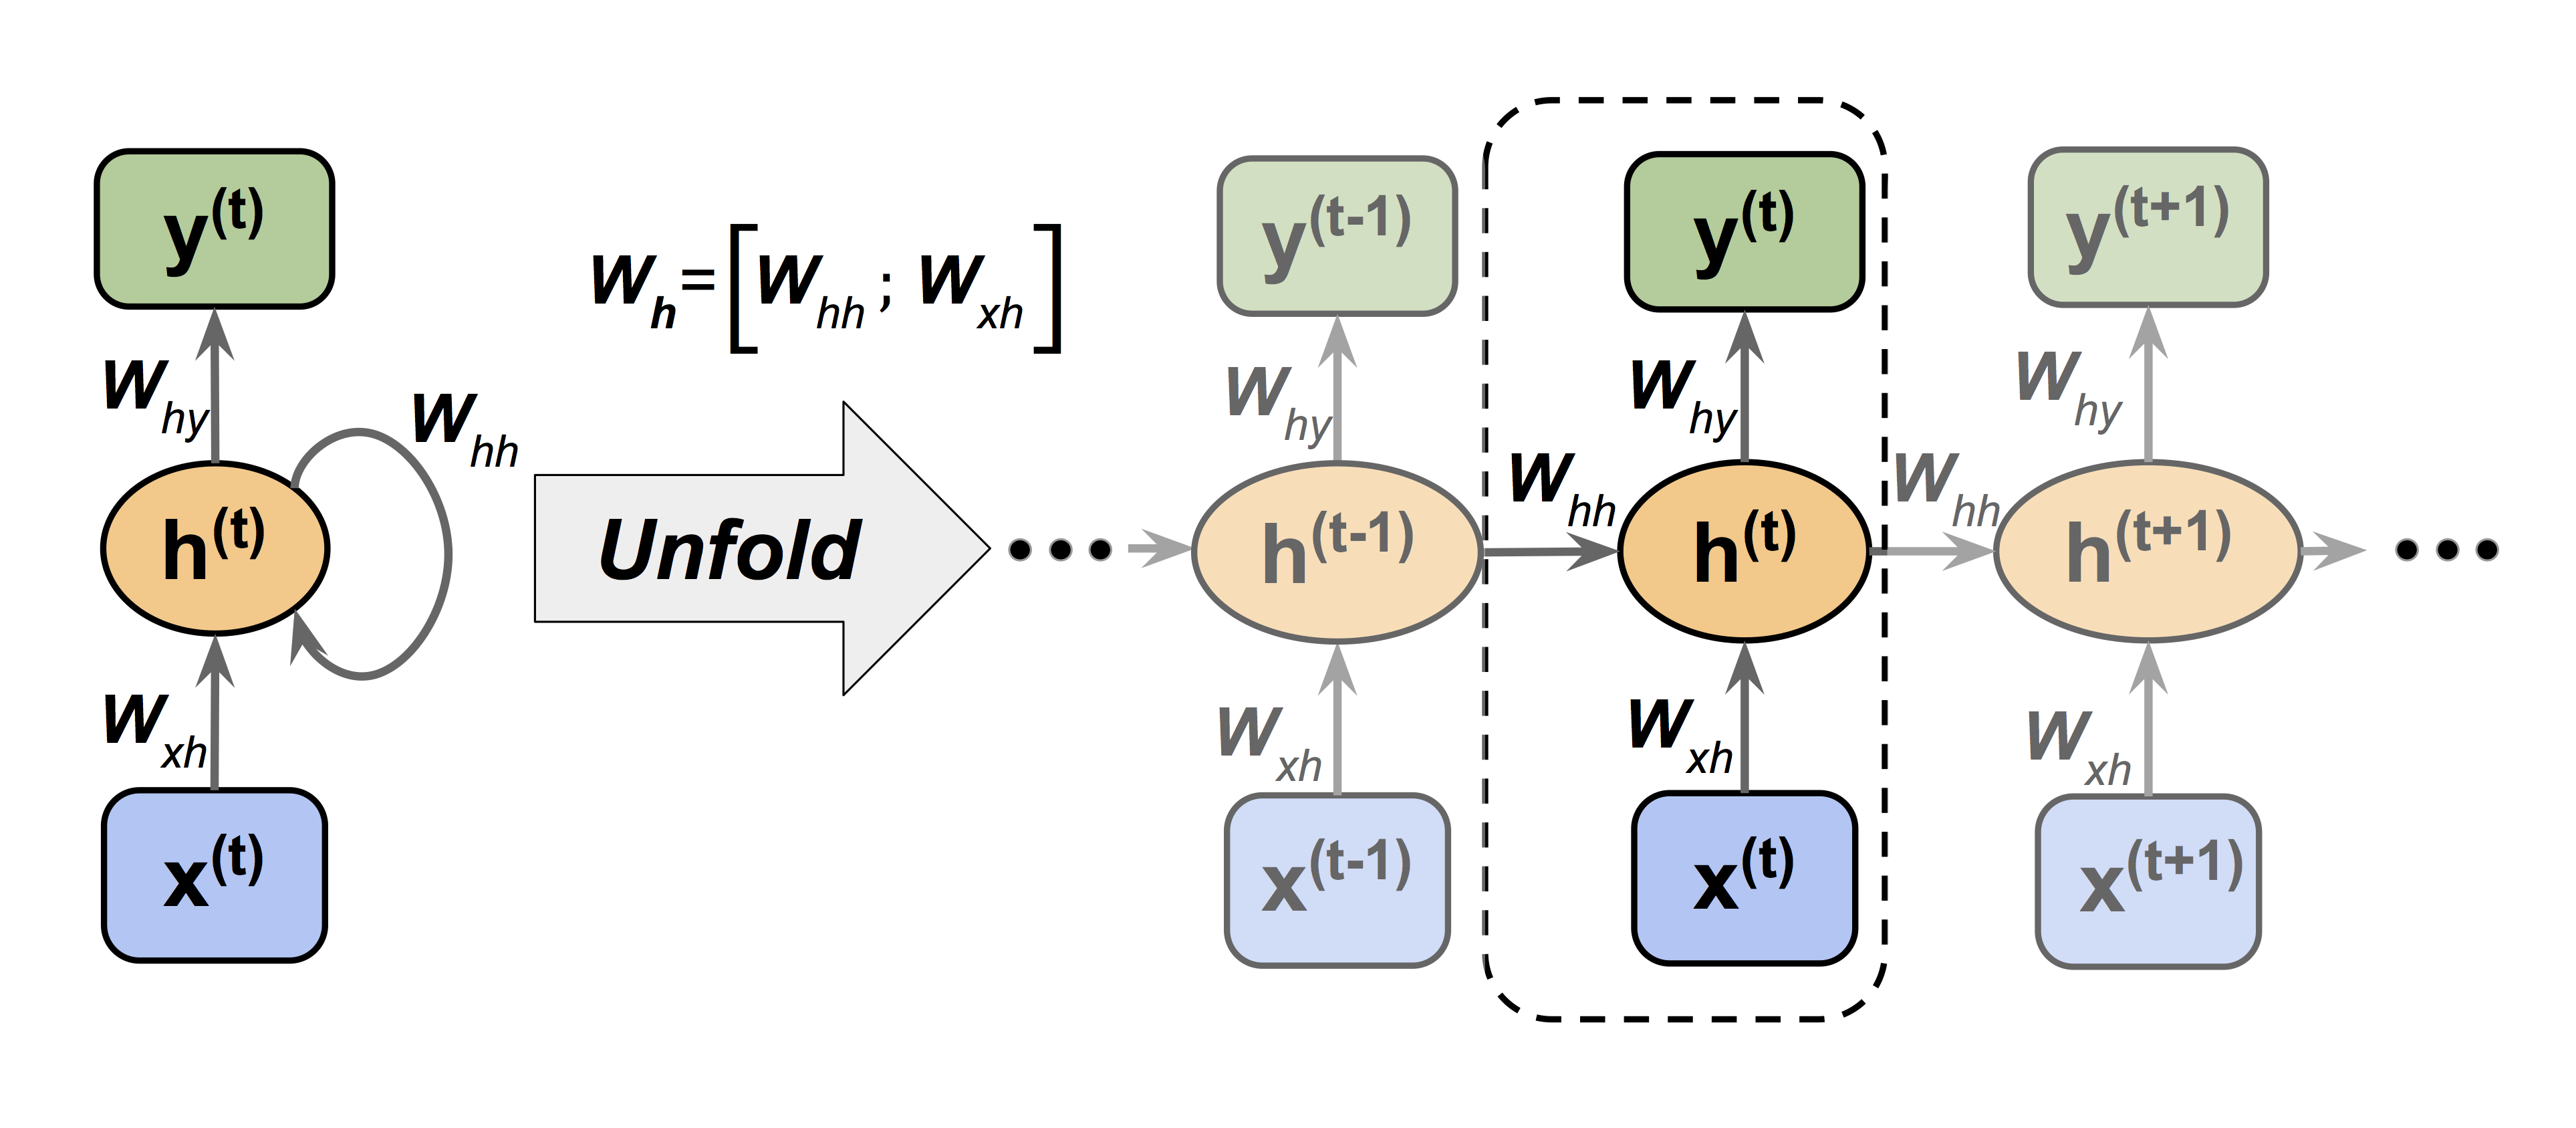

In [8]:
Image(filename='images/16_05.png', width=600) 

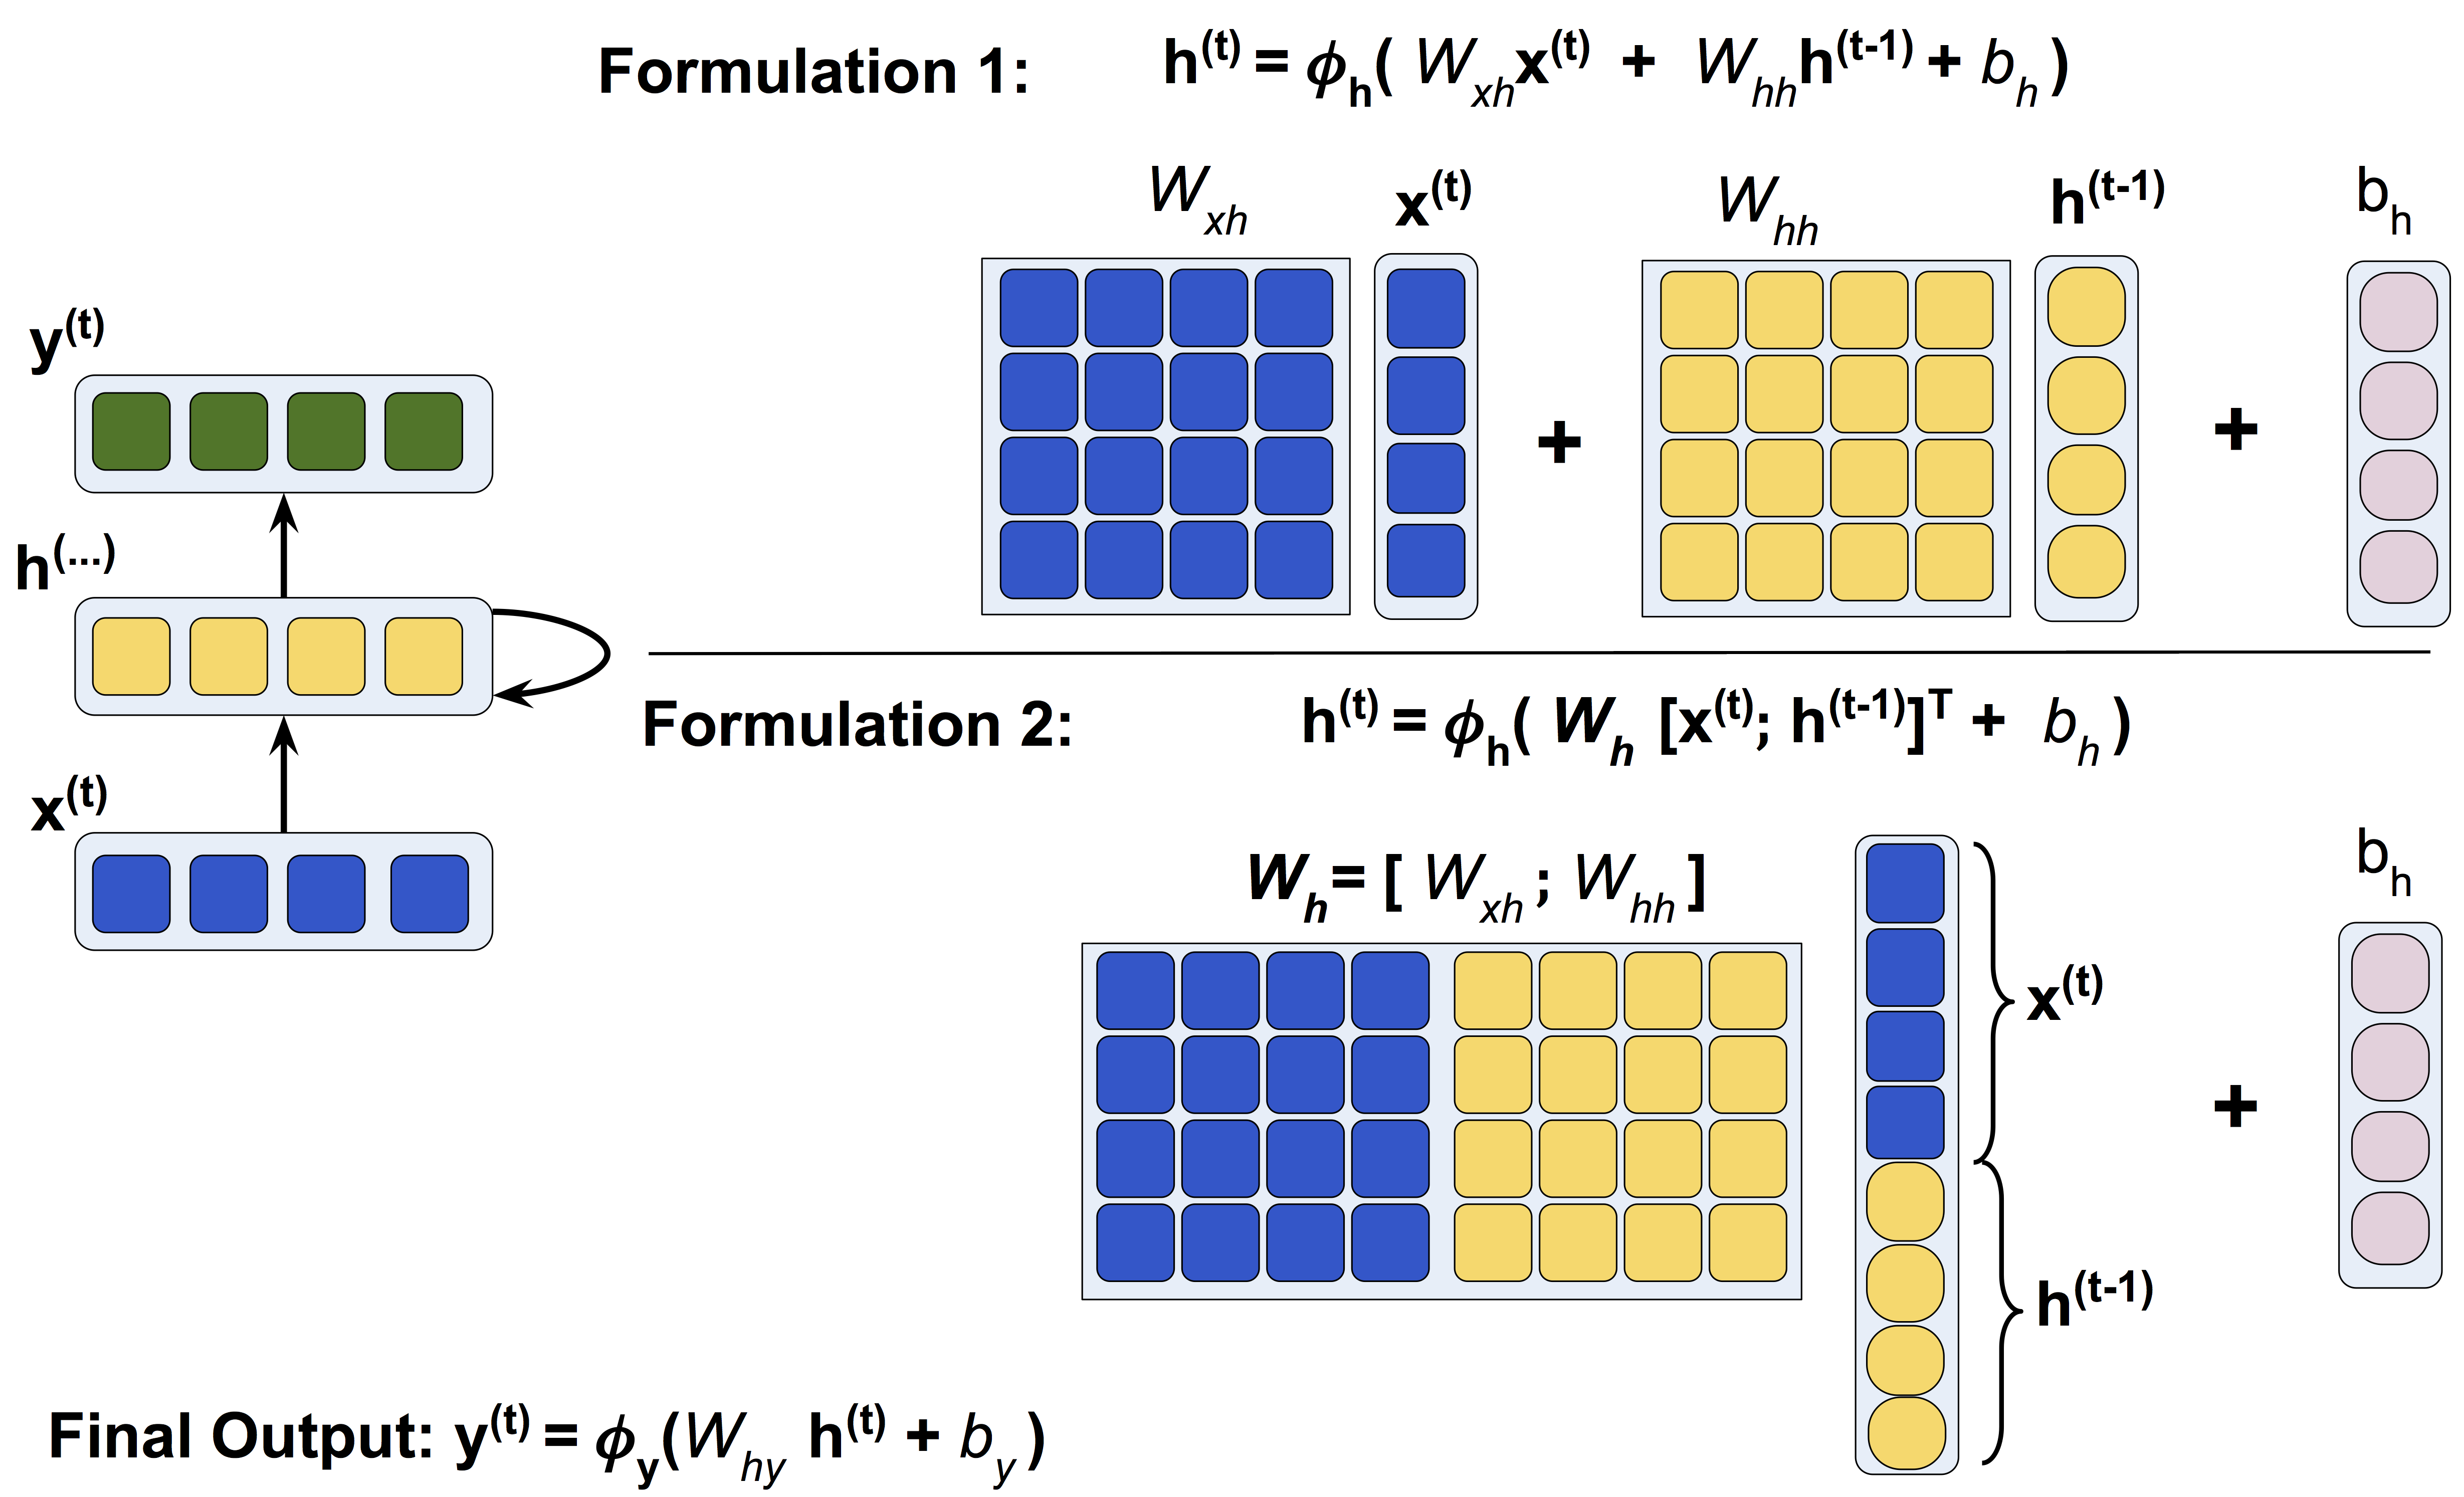

In [9]:
Image(filename='images/16_06.png', width=600) 

## The challenges of learning long-range interactions

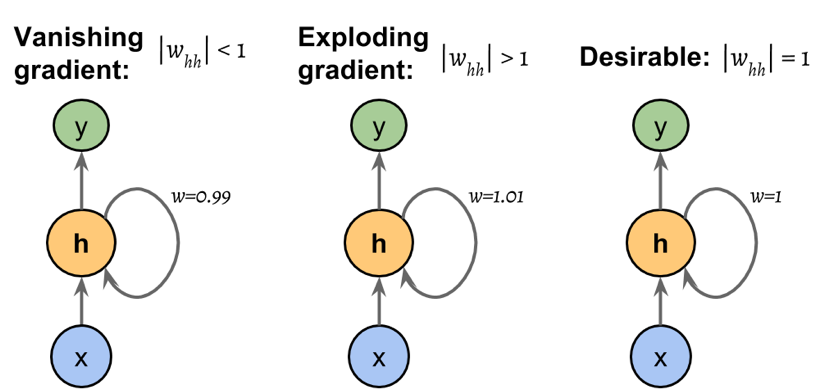

In [10]:
Image(filename='images/16_07.png', width=600) 

## Long short-term memory units

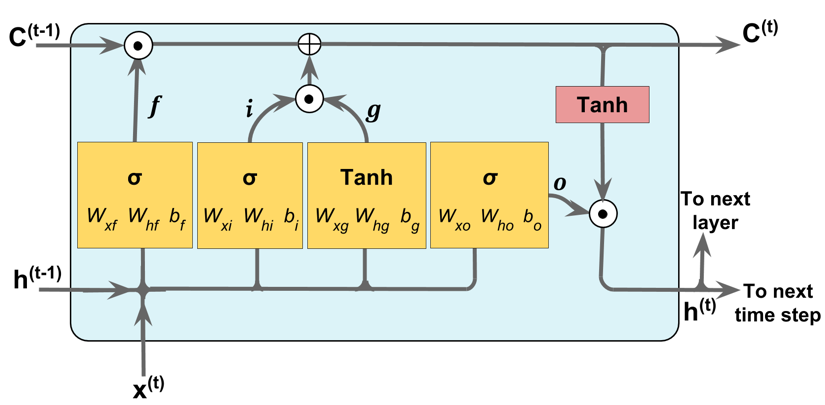

In [11]:
Image(filename='images/16_08.png', width=600) 

# Implementing a multilayer RNN for sequence modeling in TensorFlow

## Performing sentiment analysis of IMDb movie reviews using multilayer RNNs

### Preparing the data

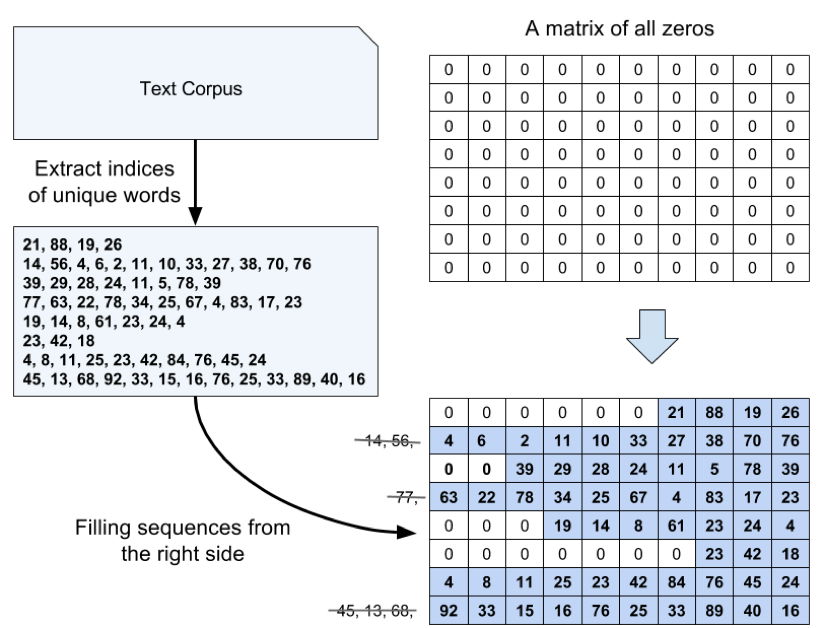

In [12]:
Image(filename='images/16_09.png', width=600) 

In [13]:
import pyprind
import pandas as pd
from string import punctuation
import re
import numpy as np


df = pd.read_csv('movie_data.csv', encoding='utf-8')
print(df.head(3))

                                              review  sentiment
0  In 1974, the teenager Martha Moxley (Maggie Gr...          1
1  OK... so... I really like Kris Kristofferson a...          0
2  ***SPOILER*** Do not read this, if you think a...          0


In [14]:
## @Readers: PLEASE IGNORE THIS CELL
##
## This cell is meant to shrink the
## dataset when this notebook is run 
## on the Travis Continuous Integration
## platform to test the code as well as
## speeding up the run using a smaller
## dataset for debugging

import os


if 'TRAVIS' in os.environ:
    df = pd.read_csv('movie_data.csv', encoding='utf-8', nrows=500)

In [15]:
## Preprocessing the data:
## Separate words and 
## count each word's occurrence


from collections import Counter


counts = Counter()
pbar = pyprind.ProgBar(len(df['review']),
                       title='Counting words occurences')
for i,review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' ' \
                    for c in review]).lower()
    df.loc[i,'review'] = text
    pbar.update()
    counts.update(text.split())

Counting words occurences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:04:16


In [16]:
## Create a mapping:
## Map each unique word to an integer

word_counts = sorted(counts, key=counts.get, reverse=True)
print(word_counts[:5])
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}


mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']),
                       title='Map reviews to ints')
for review in df['review']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])
    pbar.update()

Map reviews to ints


['the', '.', ',', 'and', 'a']


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


In [17]:
## Define fixed-length sequences:
## Use the last 200 elements of each sequence
## if sequence length < 200: left-pad with zeros

sequence_length = 200  ## sequence length (or T in our formulas)
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=int)
for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    sequences[i, -len(row):] = review_arr[-sequence_length:]

X_train = sequences[:25000, :]
y_train = df.loc[:25000, 'sentiment'].values
X_test = sequences[25000:, :]
y_test = df.loc[25000:, 'sentiment'].values


np.random.seed(123) # for reproducibility

## Function to generate minibatches:
def create_batch_generator(x, y=None, batch_size=64):
    n_batches = len(x)//batch_size
    x= x[:n_batches*batch_size]
    if y is not None:
        y = y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        if y is not None:
            yield x[ii:ii+batch_size], y[ii:ii+batch_size]
        else:
            yield x[ii:ii+batch_size]

In [18]:
## @Readers: PLEASE IGNORE THIS CELL
##
## This cell is meant to shrink the
## dataset when this notebook is run 
## on the Travis Continuous Integration
## platform to test the code as well as
## speeding up the run using a smaller
## dataset for debugging

if 'TRAVIS' in os.environ:
    X_train = sequences[:250, :]
    y_train = df.loc[:250, 'sentiment'].values
    X_test = sequences[250:500, :]
    y_test = df.loc[250:500, 'sentiment'].values

### Embedding

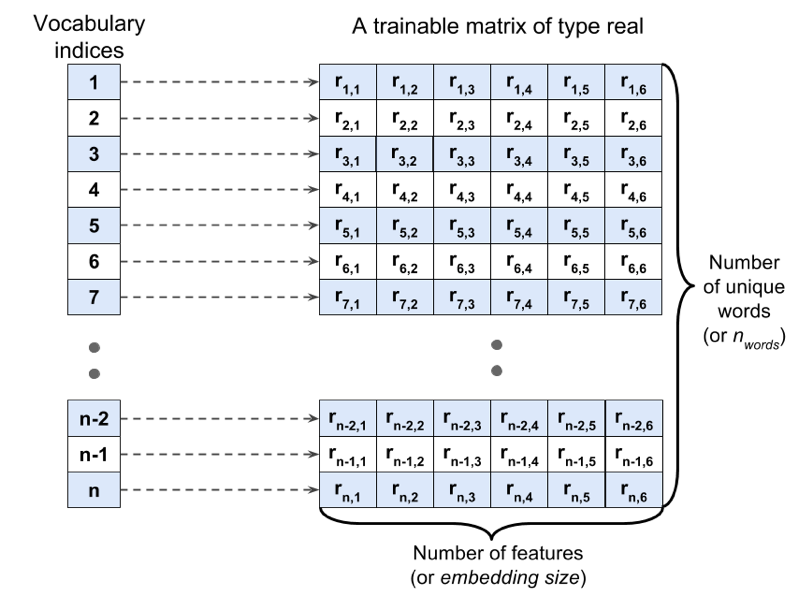

In [19]:
Image(filename='images/16_10.png', width=600) 

### Building the RNN model

In [20]:
import tensorflow as tf


class SentimentRNN(object):
    def __init__(self, n_words, seq_len=200,
                 lstm_size=256, num_layers=1, batch_size=64,
                 learning_rate=0.0001, embed_size=200):
        self.n_words = n_words
        self.seq_len = seq_len
        self.lstm_size = lstm_size   ## number of hidden units
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.embed_size = embed_size

        self.g = tf.Graph()
        with self.g.as_default():
            tf.set_random_seed(123)
            self.build()
            self.saver = tf.train.Saver()
            self.init_op = tf.global_variables_initializer()

    def build(self):
        ## Define the placeholders
        tf_x = tf.placeholder(tf.int32,
                    shape=(self.batch_size, self.seq_len),
                    name='tf_x')
        tf_y = tf.placeholder(tf.float32,
                    shape=(self.batch_size),
                    name='tf_y')
        tf_keepprob = tf.placeholder(tf.float32,
                    name='tf_keepprob')
        ## Create the embedding layer
        embedding = tf.Variable(
                    tf.random_uniform(
                        (self.n_words, self.embed_size),
                        minval=-1, maxval=1),
                    name='embedding')
        embed_x = tf.nn.embedding_lookup(
                    embedding, tf_x, 
                    name='embeded_x')

        ## Define LSTM cell and stack them together
        cells = tf.contrib.rnn.MultiRNNCell(
                [tf.contrib.rnn.DropoutWrapper(
                   tf.contrib.rnn.BasicLSTMCell(self.lstm_size),
                   output_keep_prob=tf_keepprob)
                 for i in range(self.num_layers)])

        ## Define the initial state:
        self.initial_state = cells.zero_state(
                 self.batch_size, tf.float32)
        print('  << initial state >> ', self.initial_state)

        lstm_outputs, self.final_state = tf.nn.dynamic_rnn(
                 cells, embed_x,
                 initial_state=self.initial_state)
        ## Note: lstm_outputs shape: 
        ##  [batch_size, max_time, cells.output_size]
        print('\n  << lstm_output   >> ', lstm_outputs)
        print('\n  << final state   >> ', self.final_state)

        ## Apply a FC layer after on top of RNN output:
        logits = tf.layers.dense(
                 inputs=lstm_outputs[:, -1],
                 units=1, activation=None,
                 name='logits')
        
        logits = tf.squeeze(logits, name='logits_squeezed')
        print ('\n  << logits        >> ', logits)
        
        y_proba = tf.nn.sigmoid(logits, name='probabilities')
        predictions = {
            'probabilities': y_proba,
            'labels' : tf.cast(tf.round(y_proba), tf.int32,
                 name='labels')
        }
        print('\n  << predictions   >> ', predictions)

        ## Define the cost function
        cost = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(
                 labels=tf_y, logits=logits),
                 name='cost')
        
        ## Define the optimizer
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        train_op = optimizer.minimize(cost, name='train_op')

    def train(self, X_train, y_train, num_epochs):
        with tf.Session(graph=self.g) as sess:
            sess.run(self.init_op)
            iteration = 1
            for epoch in range(num_epochs):
                state = sess.run(self.initial_state)
                
                for batch_x, batch_y in create_batch_generator(
                            X_train, y_train, self.batch_size):
                    feed = {'tf_x:0': batch_x,
                            'tf_y:0': batch_y,
                            'tf_keepprob:0': 0.5,
                            self.initial_state : state}
                    loss, _, state = sess.run(
                            ['cost:0', 'train_op', 
                             self.final_state],
                            feed_dict=feed)

                    if iteration % 20 == 0:
                        print("Epoch: %d/%d Iteration: %d "
                              "| Train loss: %.5f" % (
                               epoch + 1, num_epochs,
                               iteration, loss))

                    iteration +=1
                if (epoch+1)%10 == 0:
                    self.saver.save(sess,
                        "model/sentiment-%d.ckpt" % epoch)

    def predict(self, X_data, return_proba=False):
        preds = []
        with tf.Session(graph = self.g) as sess:
            self.saver.restore(
                sess, tf.train.latest_checkpoint('model/'))
            test_state = sess.run(self.initial_state)
            for ii, batch_x in enumerate(
                create_batch_generator(
                    X_data, None, batch_size=self.batch_size), 1):
                feed = {'tf_x:0' : batch_x,
                        'tf_keepprob:0': 1.0,
                        self.initial_state : test_state}
                if return_proba:
                    pred, test_state = sess.run(
                        ['probabilities:0', self.final_state],
                        feed_dict=feed)
                else:
                    pred, test_state = sess.run(
                        ['labels:0', self.final_state],
                        feed_dict=feed)
                    
                preds.append(pred)
                
        return np.concatenate(preds)

#### Step 1: Defining multilayer RNN cells

#### Step 2: Defining the initial states for the RNN cells


#### Step 3: Creating the recurrent neural network using the RNN cells and their states



In [21]:
## Train:

n_words = max(list(word_to_int.values())) + 1

rnn = SentimentRNN(n_words=n_words, 
                   seq_len=sequence_length,
                   embed_size=256, 
                   lstm_size=128, 
                   num_layers=1, 
                   batch_size=100, 
                   learning_rate=0.001)


/srv/venv/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:539: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


  << initial state >>  (LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros:0' shape=(100, 128) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros_1:0' shape=(100, 128) dtype=float32>),)

  << lstm_output   >>  Tensor("rnn/transpose_1:0", shape=(100, 200, 128), dtype=float32)

  << final state   >>  (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(100, 128) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(100, 128) dtype=float32>),)

  << logits        >>  Tensor("logits_squeezed:0", shape=(100,), dtype=float32)

  << predictions   >>  {'probabilities': <tf.Tensor 'probabilities:0' shape=(100,) dtype=float32>, 'labels': <tf.Tensor 'labels:0' shape=(100,) dtype=int32>}


In [22]:
rnn.train(X_train, y_train, num_epochs=40)

Epoch: 1/40 Iteration: 20 | Train loss: 0.69553
Epoch: 1/40 Iteration: 40 | Train loss: 0.63919
Epoch: 1/40 Iteration: 60 | Train loss: 0.69179
Epoch: 1/40 Iteration: 80 | Train loss: 0.55370
Epoch: 1/40 Iteration: 100 | Train loss: 0.57882
Epoch: 1/40 Iteration: 120 | Train loss: 0.51931
Epoch: 1/40 Iteration: 140 | Train loss: 0.40990
Epoch: 1/40 Iteration: 160 | Train loss: 0.46159
Epoch: 1/40 Iteration: 180 | Train loss: 0.50052
Epoch: 1/40 Iteration: 200 | Train loss: 0.48127
Epoch: 1/40 Iteration: 220 | Train loss: 0.43454
Epoch: 1/40 Iteration: 240 | Train loss: 0.42244
Epoch: 2/40 Iteration: 260 | Train loss: 0.39458
Epoch: 2/40 Iteration: 280 | Train loss: 0.27828
Epoch: 2/40 Iteration: 300 | Train loss: 0.29096
Epoch: 2/40 Iteration: 320 | Train loss: 0.40858
Epoch: 2/40 Iteration: 340 | Train loss: 0.30489
Epoch: 2/40 Iteration: 360 | Train loss: 0.25513
Epoch: 2/40 Iteration: 380 | Train loss: 0.36606
Epoch: 2/40 Iteration: 400 | Train loss: 0.29785
Epoch: 2/40 Iteration: 4

Epoch: 14/40 Iteration: 3300 | Train loss: 0.00918
Epoch: 14/40 Iteration: 3320 | Train loss: 0.01198
Epoch: 14/40 Iteration: 3340 | Train loss: 0.01162
Epoch: 14/40 Iteration: 3360 | Train loss: 0.00191
Epoch: 14/40 Iteration: 3380 | Train loss: 0.04806
Epoch: 14/40 Iteration: 3400 | Train loss: 0.00646
Epoch: 14/40 Iteration: 3420 | Train loss: 0.01790
Epoch: 14/40 Iteration: 3440 | Train loss: 0.02371
Epoch: 14/40 Iteration: 3460 | Train loss: 0.01090
Epoch: 14/40 Iteration: 3480 | Train loss: 0.00315
Epoch: 14/40 Iteration: 3500 | Train loss: 0.00166
Epoch: 15/40 Iteration: 3520 | Train loss: 0.07126
Epoch: 15/40 Iteration: 3540 | Train loss: 0.05484
Epoch: 15/40 Iteration: 3560 | Train loss: 0.01073
Epoch: 15/40 Iteration: 3580 | Train loss: 0.01087
Epoch: 15/40 Iteration: 3600 | Train loss: 0.01673
Epoch: 15/40 Iteration: 3620 | Train loss: 0.00417
Epoch: 15/40 Iteration: 3640 | Train loss: 0.00562
Epoch: 15/40 Iteration: 3660 | Train loss: 0.00193
Epoch: 15/40 Iteration: 3680 | 

Epoch: 27/40 Iteration: 6520 | Train loss: 0.00170
Epoch: 27/40 Iteration: 6540 | Train loss: 0.00034
Epoch: 27/40 Iteration: 6560 | Train loss: 0.00196
Epoch: 27/40 Iteration: 6580 | Train loss: 0.00334
Epoch: 27/40 Iteration: 6600 | Train loss: 0.00311
Epoch: 27/40 Iteration: 6620 | Train loss: 0.00015
Epoch: 27/40 Iteration: 6640 | Train loss: 0.00028
Epoch: 27/40 Iteration: 6660 | Train loss: 0.00359
Epoch: 27/40 Iteration: 6680 | Train loss: 0.00113
Epoch: 27/40 Iteration: 6700 | Train loss: 0.00062
Epoch: 27/40 Iteration: 6720 | Train loss: 0.00177
Epoch: 27/40 Iteration: 6740 | Train loss: 0.00026
Epoch: 28/40 Iteration: 6760 | Train loss: 0.00042
Epoch: 28/40 Iteration: 6780 | Train loss: 0.05014
Epoch: 28/40 Iteration: 6800 | Train loss: 0.00848
Epoch: 28/40 Iteration: 6820 | Train loss: 0.00129
Epoch: 28/40 Iteration: 6840 | Train loss: 0.00344
Epoch: 28/40 Iteration: 6860 | Train loss: 0.00021
Epoch: 28/40 Iteration: 6880 | Train loss: 0.00052
Epoch: 28/40 Iteration: 6900 | 

Epoch: 39/40 Iteration: 9740 | Train loss: 0.00001
Epoch: 40/40 Iteration: 9760 | Train loss: 0.00001
Epoch: 40/40 Iteration: 9780 | Train loss: 0.00001
Epoch: 40/40 Iteration: 9800 | Train loss: 0.00001
Epoch: 40/40 Iteration: 9820 | Train loss: 0.00005
Epoch: 40/40 Iteration: 9840 | Train loss: 0.00003
Epoch: 40/40 Iteration: 9860 | Train loss: 0.00002
Epoch: 40/40 Iteration: 9880 | Train loss: 0.00001
Epoch: 40/40 Iteration: 9900 | Train loss: 0.00002
Epoch: 40/40 Iteration: 9920 | Train loss: 0.00015
Epoch: 40/40 Iteration: 9940 | Train loss: 0.00007
Epoch: 40/40 Iteration: 9960 | Train loss: 0.00001
Epoch: 40/40 Iteration: 9980 | Train loss: 0.00002
Epoch: 40/40 Iteration: 10000 | Train loss: 0.00001


In [23]:
## Test: 
preds = rnn.predict(X_test)
y_true = y_test[:len(preds)]
print('Test Acc.: %.3f' % (
      np.sum(preds == y_true) / len(y_true)))

INFO:tensorflow:Restoring parameters from model/sentiment-39.ckpt
Test Acc.: 0.860


In [24]:
## Get probabilities:
proba = rnn.predict(X_test, return_proba=True)

INFO:tensorflow:Restoring parameters from model/sentiment-39.ckpt


## Example application: character-level language modeling

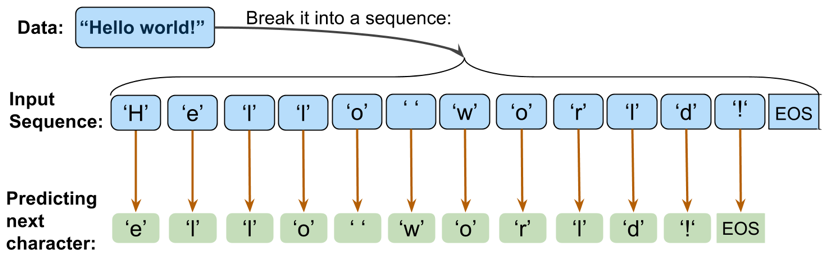

In [25]:
Image(filename='images/16_11.png', width=600) 

### Preparing the data


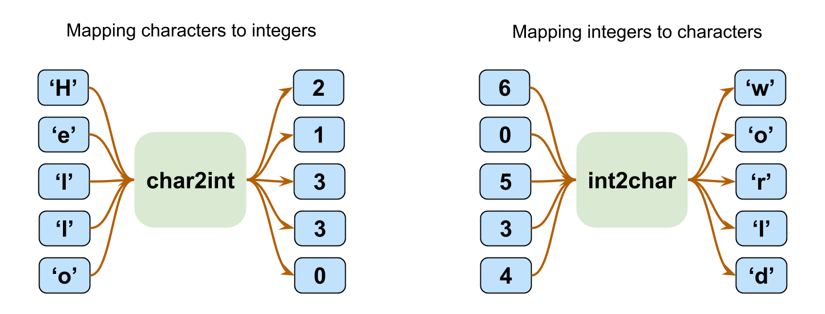

In [26]:
Image(filename='images/16_12.png', width=600) 

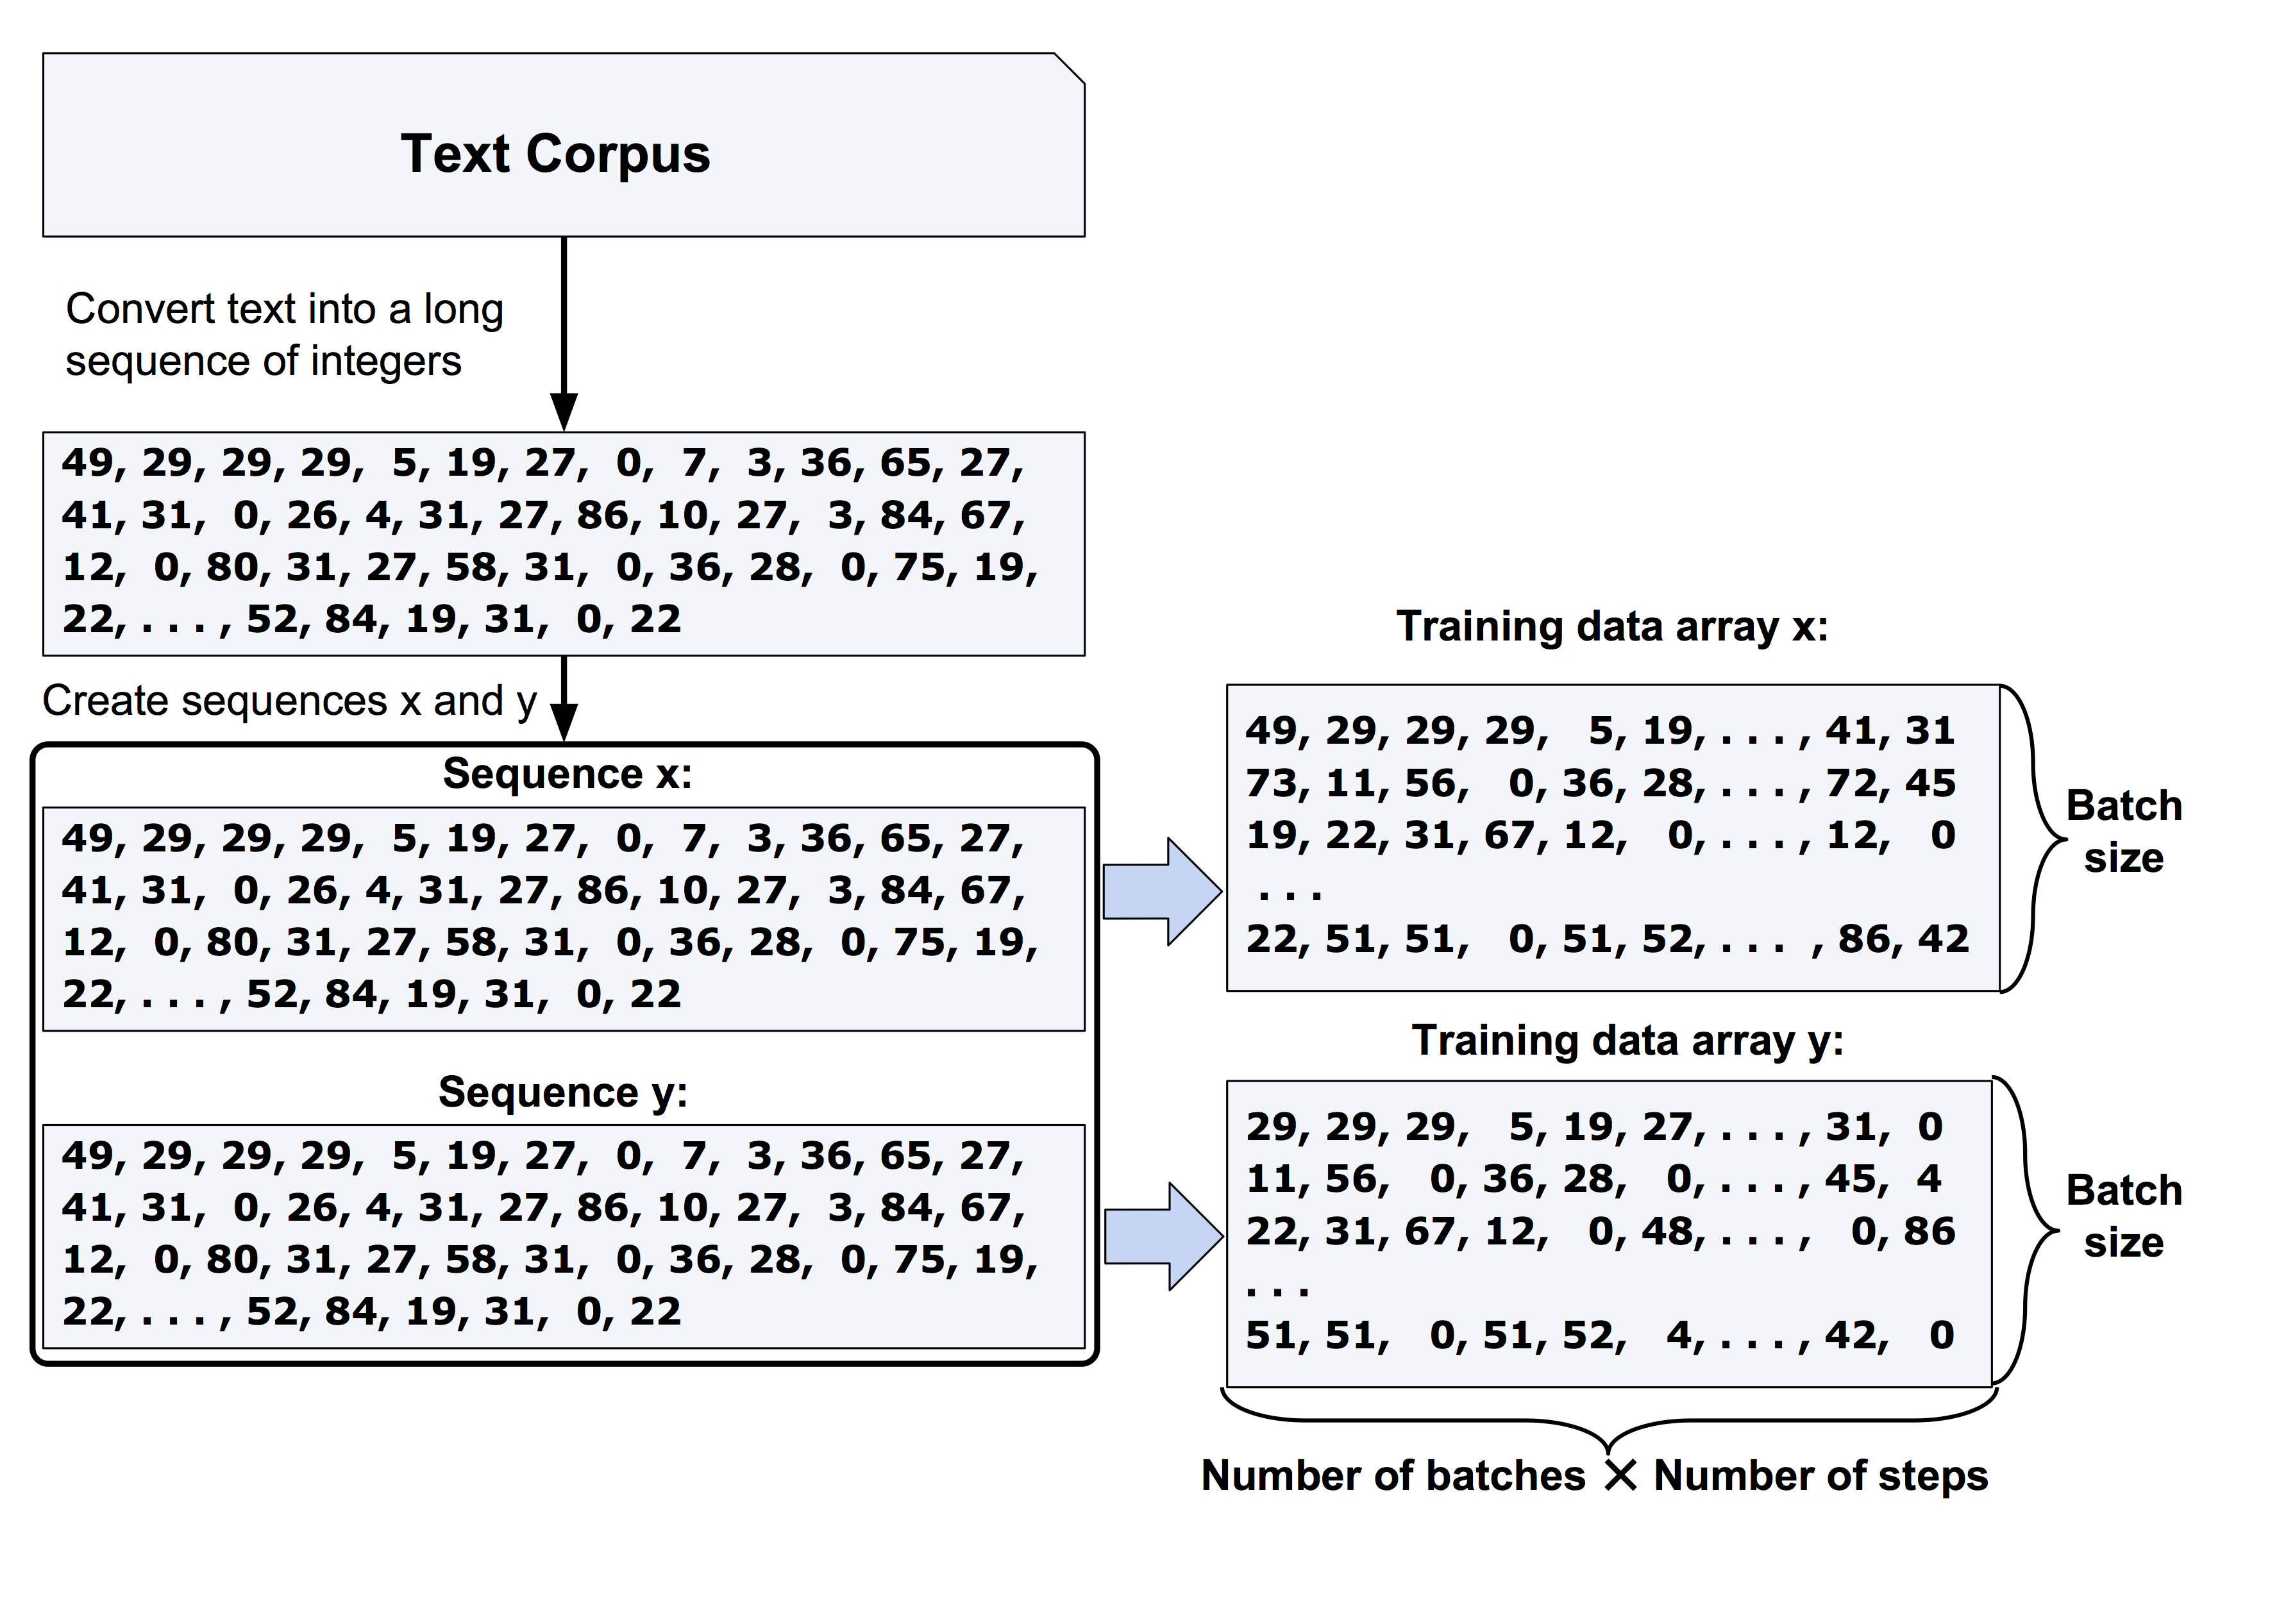

In [27]:
Image(filename='images/16_13.png', width=600) 

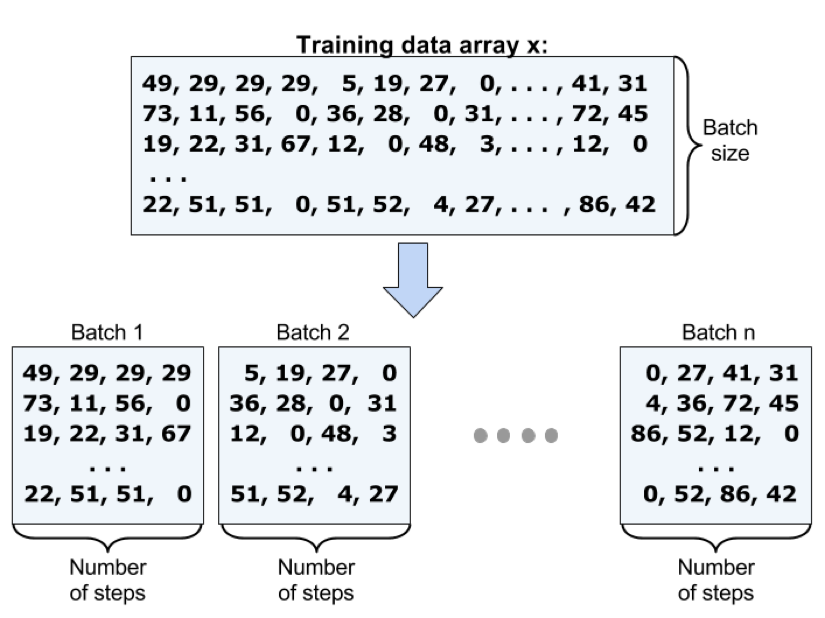

In [28]:
Image(filename='images/16_14.png', width=600) 

In [29]:
import numpy as np


## Reading and processing text
with open('pg2265.txt', 'r', encoding='utf-8') as f: 
    text=f.read()

text = text[15858:]
chars = set(text)
char2int = {ch:i for i,ch in enumerate(chars)}
int2char = dict(enumerate(chars))
text_ints = np.array([char2int[ch] for ch in text], 
                     dtype=np.int32)

In [30]:
## @Readers: PLEASE IGNORE THIS CELL
##
## This cell is meant to shrink the
## dataset when this notebook is run 
## on the Travis Continuous Integration
## platform to test the code as well as
## speeding up the run using a smaller
## dataset for debugging

if 'TRAVIS' in os.environ:
    text = text[:1000]
    chars = set(text)
    char2int = {ch:i for i,ch in enumerate(chars)}
    int2char = dict(enumerate(chars))
    text_ints = np.array([char2int[ch] for ch in text], 
                         dtype=np.int32)

In [31]:
def reshape_data(sequence, batch_size, num_steps):
    tot_batch_length = batch_size * num_steps
    num_batches = int(len(sequence) / tot_batch_length)
    if num_batches*tot_batch_length + 1 > len(sequence):
        num_batches = num_batches - 1
    ## Truncate the sequence at the end to get rid of 
    ## remaining charcaters that do not make a full batch
    x = sequence[0 : num_batches*tot_batch_length]
    y = sequence[1 : num_batches*tot_batch_length + 1]
    ## Split x & y into a list batches of sequences: 
    x_batch_splits = np.split(x, batch_size)
    y_batch_splits = np.split(y, batch_size)
    ## Stack the batches together
    ## batch_size x tot_batch_length
    x = np.stack(x_batch_splits)
    y = np.stack(y_batch_splits)
    
    return x, y

## Testing:
train_x, train_y = reshape_data(text_ints, 64, 10)
print(train_x.shape)
print(train_x[0, :10])
print(train_y[0, :10])
print(''.join(int2char[i] for i in train_x[0, :50]))

(64, 2540)
[45 41 53 32 45 29  0  6 53 33]
[41 53 32 45 29  0  6 53 33  2]
The Tragedie of Hamlet

Actus Primus. Scoena Prima


In [32]:
np.random.seed(123)

def create_batch_generator(data_x, data_y, num_steps):
    batch_size, tot_batch_length = data_x.shape    
    num_batches = int(tot_batch_length/num_steps)
    for b in range(num_batches):
        yield (data_x[:, b*num_steps: (b+1)*num_steps], 
               data_y[:, b*num_steps: (b+1)*num_steps])
        
bgen = create_batch_generator(train_x[:,:100], train_y[:,:100], 15)
for b in bgen:
    print(b[0].shape, b[1].shape, end='  ')
    print(''.join(int2char[i] for i in b[0][0,:]).replace('\n', '*'), '    ',
          ''.join(int2char[i] for i in b[1][0,:]).replace('\n', '*'))

(64, 15) (64, 15)  The Tragedie of      he Tragedie of 
(64, 15) (64, 15)   Hamlet**Actus       Hamlet**Actus P
(64, 15) (64, 15)  Primus. Scoena       rimus. Scoena P
(64, 15) (64, 15)  Prima.**Enter B      rima.**Enter Ba
(64, 15) (64, 15)  arnardo and Fra      rnardo and Fran
(64, 15) (64, 15)  ncisco two Cent      cisco two Centi


### Building the character-level RNN model

In [33]:
import tensorflow as tf
import os

class CharRNN(object):
    def __init__(self, num_classes, batch_size=64, 
                 num_steps=100, lstm_size=128, 
                 num_layers=1, learning_rate=0.001, 
                 keep_prob=0.5, grad_clip=5, 
                 sampling=False):
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.grad_clip = grad_clip
        
        self.g = tf.Graph()
        with self.g.as_default():
            tf.set_random_seed(123)

            self.build(sampling=sampling)
            self.saver = tf.train.Saver()
            self.init_op = tf.global_variables_initializer()
            
    def build(self, sampling):
        if sampling == True:
            batch_size, num_steps = 1, 1
        else:
            batch_size = self.batch_size
            num_steps = self.num_steps

        tf_x = tf.placeholder(tf.int32, 
                              shape=[batch_size, num_steps], 
                              name='tf_x')
        tf_y = tf.placeholder(tf.int32, 
                              shape=[batch_size, num_steps], 
                              name='tf_y')
        tf_keepprob = tf.placeholder(tf.float32, 
                              name='tf_keepprob')

        # One-hot encoding:
        x_onehot = tf.one_hot(tf_x, depth=self.num_classes)
        y_onehot = tf.one_hot(tf_y, depth=self.num_classes)

        ### Build the multi-layer RNN cells
        cells = tf.contrib.rnn.MultiRNNCell(
            [tf.contrib.rnn.DropoutWrapper(
                tf.contrib.rnn.BasicLSTMCell(self.lstm_size), 
                output_keep_prob=tf_keepprob) 
            for _ in range(self.num_layers)])
        
        ## Define the initial state
        self.initial_state = cells.zero_state(
                    batch_size, tf.float32)

        ## Run each sequence step through the RNN 
        lstm_outputs, self.final_state = tf.nn.dynamic_rnn(
                    cells, x_onehot, 
                    initial_state=self.initial_state)
        
        print('  << lstm_outputs  >>', lstm_outputs)

        seq_output_reshaped = tf.reshape(
                    lstm_outputs, 
                    shape=[-1, self.lstm_size],
                    name='seq_output_reshaped')

        logits = tf.layers.dense(
                    inputs=seq_output_reshaped, 
                    units=self.num_classes,
                    activation=None,
                    name='logits')

        proba = tf.nn.softmax(
                    logits, 
                    name='probabilities')
        print(proba)

        y_reshaped = tf.reshape(
                    y_onehot, 
                    shape=[-1, self.num_classes],
                    name='y_reshaped')
        cost = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits(
                        logits=logits, 
                        labels=y_reshaped),
                    name='cost')

        # Gradient clipping to avoid "exploding gradients"
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(
                    tf.gradients(cost, tvars), 
                    self.grad_clip)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        train_op = optimizer.apply_gradients(
                    zip(grads, tvars),
                    name='train_op')
        
    def train(self, train_x, train_y, 
              num_epochs, ckpt_dir='./model/'):
        ## Create the checkpoint directory
        ## if does not exists
        if not os.path.exists(ckpt_dir):
            os.mkdir(ckpt_dir)
            
        with tf.Session(graph=self.g) as sess:
            sess.run(self.init_op)

            n_batches = int(train_x.shape[1]/self.num_steps)
            iterations = n_batches * num_epochs
            for epoch in range(num_epochs):

                # Train network
                new_state = sess.run(self.initial_state)
                loss = 0
                ## Minibatch generator:
                bgen = create_batch_generator(
                        train_x, train_y, self.num_steps)
                for b, (batch_x, batch_y) in enumerate(bgen, 1):
                    iteration = epoch*n_batches + b
                    
                    feed = {'tf_x:0': batch_x,
                            'tf_y:0': batch_y,
                            'tf_keepprob:0': self.keep_prob,
                            self.initial_state : new_state}
                    batch_cost, _, new_state = sess.run(
                            ['cost:0', 'train_op', 
                                self.final_state],
                            feed_dict=feed)
                    if iteration % 10 == 0:
                        print('Epoch %d/%d Iteration %d'
                              '| Training loss: %.4f' % (
                              epoch + 1, num_epochs, 
                              iteration, batch_cost))

                ## Save the trained model    
                self.saver.save(
                        sess, os.path.join(
                            ckpt_dir, 'language_modeling.ckpt'))
                              
                              
                
    def sample(self, output_length, 
               ckpt_dir, starter_seq="The "):
        observed_seq = [ch for ch in starter_seq]        
        with tf.Session(graph=self.g) as sess:
            self.saver.restore(
                sess, 
                tf.train.latest_checkpoint(ckpt_dir))
            ## 1: run the model using the starter sequence
            new_state = sess.run(self.initial_state)
            for ch in starter_seq:
                x = np.zeros((1, 1))
                x[0,0] = char2int[ch]
                feed = {'tf_x:0': x,
                        'tf_keepprob:0': 1.0,
                        self.initial_state: new_state}
                proba, new_state = sess.run(
                        ['probabilities:0', self.final_state], 
                        feed_dict=feed)

            ch_id = get_top_char(proba, len(chars))
            observed_seq.append(int2char[ch_id])
            
            ## 2: run the model using the updated observed_seq
            for i in range(output_length):
                x[0,0] = ch_id
                feed = {'tf_x:0': x,
                        'tf_keepprob:0': 1.0,
                        self.initial_state: new_state}
                proba, new_state = sess.run(
                        ['probabilities:0', self.final_state], 
                        feed_dict=feed)

                ch_id = get_top_char(proba, len(chars))
                observed_seq.append(int2char[ch_id])

        return ''.join(observed_seq)


In [34]:
def get_top_char(probas, char_size, top_n=5):
    p = np.squeeze(probas)
    p[np.argsort(p)[:-top_n]] = 0.0
    p = p / np.sum(p)
    ch_id = np.random.choice(char_size, 1, p=p)[0]
    return ch_id

In [35]:
batch_size = 64
num_steps = 100 
train_x, train_y = reshape_data(text_ints, 
                                batch_size, 
                                num_steps)

rnn = CharRNN(num_classes=len(chars), batch_size=batch_size)
rnn.train(train_x, train_y, 
          num_epochs=100,
          ckpt_dir='./model-100/')

/srv/venv/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:539: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


  << lstm_outputs  >> Tensor("rnn/transpose_1:0", shape=(64, 100, 128), dtype=float32)
Tensor("probabilities:0", shape=(6400, 65), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch 1/100 Iteration 10| Training loss: 3.7269
Epoch 1/100 Iteration 20| Training loss: 3.3690
Epoch 2/100 Iteration 30| Training loss: 3.2946
Epoch 2/100 Iteration 40| Training loss: 3.2461
Epoch 2/100 Iteration 50| Training loss: 3.2249
Epoch 3/100 Iteration 60| Training loss: 3.2188
Epoch 3/100 Iteration 70| Training loss: 3.1813
Epoch 4/100 Iteration 80| Training loss: 3.1726
Epoch 4/100 Iteration 90| Training loss: 3.1510
Epoch 4/100 Iteration 100| Training loss: 3.1381
Epoch 5/100 Iteration 110| Training loss: 3.1276
Epoch 5/100 Iteration 120| Training loss: 3.0834
Epoch 6/100 Iteration 130| Training loss: 3.0607
Epoch 6/100 Iteration 140| Training l

Epoch 62/100 Iteration 1540| Training loss: 2.0325
Epoch 62/100 Iteration 1550| Training loss: 1.9783
Epoch 63/100 Iteration 1560| Training loss: 2.0259
Epoch 63/100 Iteration 1570| Training loss: 1.9958
Epoch 64/100 Iteration 1580| Training loss: 2.0065
Epoch 64/100 Iteration 1590| Training loss: 2.0299
Epoch 64/100 Iteration 1600| Training loss: 1.9680
Epoch 65/100 Iteration 1610| Training loss: 2.0196
Epoch 65/100 Iteration 1620| Training loss: 2.0050
Epoch 66/100 Iteration 1630| Training loss: 1.9873
Epoch 66/100 Iteration 1640| Training loss: 2.0077
Epoch 66/100 Iteration 1650| Training loss: 1.9511
Epoch 67/100 Iteration 1660| Training loss: 2.0017
Epoch 67/100 Iteration 1670| Training loss: 1.9863
Epoch 68/100 Iteration 1680| Training loss: 1.9932
Epoch 68/100 Iteration 1690| Training loss: 2.0098
Epoch 68/100 Iteration 1700| Training loss: 1.9558
Epoch 69/100 Iteration 1710| Training loss: 2.0025
Epoch 69/100 Iteration 1720| Training loss: 1.9804
Epoch 70/100 Iteration 1730| Tr

In [36]:
np.random.seed(123)
rnn = CharRNN(len(chars), sampling=True)

print(rnn.sample(ckpt_dir='./model-100/', 
                 output_length=500))

  << lstm_outputs  >> Tensor("rnn/transpose_1:0", shape=(1, 1, 128), dtype=float32)
Tensor("probabilities:0", shape=(1, 65), dtype=float32)


/srv/venv/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:539: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


INFO:tensorflow:Restoring parameters from ./model-100/language_modeling.ckpt
The may.
Te thy may

   Hor. That as thy Lerd so the to thou here these anseres,
And thow in the thes sowent the Crinke that

   Ham. It that shath me a farre are will thy thene,
And what weake it makne asthe wares, it may,
Te that sist that, tay't me this sithen sall was to som

   Ham. Ile him hare

   Qu. How this the taserigh, ord out thith this deede ant my

   Ham. What shit well so tanke in the thimser andert,
And welle moul sisten my Lond, with thinge,
And what shate tit it mat it teente,
Tha


In [37]:
## run for 200 epochs
batch_size = 64
num_steps = 100 

rnn = CharRNN(num_classes=len(chars), batch_size=batch_size)
rnn.train(train_x, train_y, 
          num_epochs=200,
          ckpt_dir='./model-200/')

  << lstm_outputs  >> Tensor("rnn/transpose_1:0", shape=(64, 100, 128), dtype=float32)
Tensor("probabilities:0", shape=(6400, 65), dtype=float32)


/srv/venv/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:539: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Epoch 1/200 Iteration 10| Training loss: 3.7275
Epoch 1/200 Iteration 20| Training loss: 3.3692
Epoch 2/200 Iteration 30| Training loss: 3.2946
Epoch 2/200 Iteration 40| Training loss: 3.2462
Epoch 2/200 Iteration 50| Training loss: 3.2246
Epoch 3/200 Iteration 60| Training loss: 3.2188
Epoch 3/200 Iteration 70| Training loss: 3.1815
Epoch 4/200 Iteration 80| Training loss: 3.1727
Epoch 4/200 Iteration 90| Training loss: 3.1511
Epoch 4/200 Iteration 100| Training loss: 3.1382
Epoch 5/200 Iteration 110| Training loss: 3.1278
Epoch 5/200 Iteration 120| Training loss: 3.0835
Epoch 6/200 Iteration 130| Training loss: 3.0608
Epoch 6/200 Iteration 140| Training loss: 3.0291
Epoch 6/200 Iteration 150| Training loss: 2.9959
Epoch 7/200 Iteration 160| Training loss: 2.9730
Epoch 7/200 Iteration 170| Training loss: 2.9079
Epoch 8/200 Iteration 180| Training loss: 2.8668
Epoch 8/200 Iteration 190| Training loss: 2.8464
Epoch 8/200 Iteration 200| Training loss: 2.7859
Epoch 9/200 Iteration 210| Tr

Epoch 66/200 Iteration 1650| Training loss: 1.9512
Epoch 67/200 Iteration 1660| Training loss: 2.0018
Epoch 67/200 Iteration 1670| Training loss: 1.9864
Epoch 68/200 Iteration 1680| Training loss: 1.9945
Epoch 68/200 Iteration 1690| Training loss: 2.0105
Epoch 68/200 Iteration 1700| Training loss: 1.9574
Epoch 69/200 Iteration 1710| Training loss: 2.0031
Epoch 69/200 Iteration 1720| Training loss: 1.9786
Epoch 70/200 Iteration 1730| Training loss: 1.9827
Epoch 70/200 Iteration 1740| Training loss: 1.9903
Epoch 70/200 Iteration 1750| Training loss: 1.9466
Epoch 71/200 Iteration 1760| Training loss: 1.9831
Epoch 71/200 Iteration 1770| Training loss: 1.9630
Epoch 72/200 Iteration 1780| Training loss: 1.9841
Epoch 72/200 Iteration 1790| Training loss: 1.9873
Epoch 72/200 Iteration 1800| Training loss: 1.9345
Epoch 73/200 Iteration 1810| Training loss: 1.9868
Epoch 73/200 Iteration 1820| Training loss: 1.9594
Epoch 74/200 Iteration 1830| Training loss: 1.9688
Epoch 74/200 Iteration 1840| Tr

Epoch 130/200 Iteration 3250| Training loss: 1.7842
Epoch 131/200 Iteration 3260| Training loss: 1.8177
Epoch 131/200 Iteration 3270| Training loss: 1.8133
Epoch 132/200 Iteration 3280| Training loss: 1.8033
Epoch 132/200 Iteration 3290| Training loss: 1.8388
Epoch 132/200 Iteration 3300| Training loss: 1.7866
Epoch 133/200 Iteration 3310| Training loss: 1.8217
Epoch 133/200 Iteration 3320| Training loss: 1.8076
Epoch 134/200 Iteration 3330| Training loss: 1.8006
Epoch 134/200 Iteration 3340| Training loss: 1.8291
Epoch 134/200 Iteration 3350| Training loss: 1.7782
Epoch 135/200 Iteration 3360| Training loss: 1.8115
Epoch 135/200 Iteration 3370| Training loss: 1.7918
Epoch 136/200 Iteration 3380| Training loss: 1.8018
Epoch 136/200 Iteration 3390| Training loss: 1.8280
Epoch 136/200 Iteration 3400| Training loss: 1.7687
Epoch 137/200 Iteration 3410| Training loss: 1.8065
Epoch 137/200 Iteration 3420| Training loss: 1.8013
Epoch 138/200 Iteration 3430| Training loss: 1.7912
Epoch 138/20

Epoch 194/200 Iteration 4830| Training loss: 1.7038
Epoch 194/200 Iteration 4840| Training loss: 1.7291
Epoch 194/200 Iteration 4850| Training loss: 1.6831
Epoch 195/200 Iteration 4860| Training loss: 1.7224
Epoch 195/200 Iteration 4870| Training loss: 1.7029
Epoch 196/200 Iteration 4880| Training loss: 1.7039
Epoch 196/200 Iteration 4890| Training loss: 1.7243
Epoch 196/200 Iteration 4900| Training loss: 1.6777
Epoch 197/200 Iteration 4910| Training loss: 1.7219
Epoch 197/200 Iteration 4920| Training loss: 1.7015
Epoch 198/200 Iteration 4930| Training loss: 1.7131
Epoch 198/200 Iteration 4940| Training loss: 1.7341
Epoch 198/200 Iteration 4950| Training loss: 1.6704
Epoch 199/200 Iteration 4960| Training loss: 1.7061
Epoch 199/200 Iteration 4970| Training loss: 1.7077
Epoch 200/200 Iteration 4980| Training loss: 1.7030
Epoch 200/200 Iteration 4990| Training loss: 1.7275
Epoch 200/200 Iteration 5000| Training loss: 1.6710


In [38]:
del rnn

np.random.seed(123)
rnn = CharRNN(len(chars), sampling=True)
print(rnn.sample(ckpt_dir='./model-200/', 
                 output_length=500))

  << lstm_outputs  >> Tensor("rnn/transpose_1:0", shape=(1, 1, 128), dtype=float32)
Tensor("probabilities:0", shape=(1, 65), dtype=float32)


/srv/venv/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:539: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


INFO:tensorflow:Restoring parameters from ./model-200/language_modeling.ckpt
The toull how it as
to mo horting. There he ond haue to the more ther to toe
Treonges inde as te the toules is me some thonees.
We that then shist the sornestes of the Player

   Osr. It my Mores ant a torige

   Qu. I wares owe, what as haue take ates,
And we haue his sints and migth: Ineeere him heere:
But whose would my Lord

   Ham. Then he with hele sing to what with
The serfine. In thas this mart our to nate

   Polon. We to gut it my Lord?
  Osh. Woundery of this mines. It moringtende in,
Is w


# Summary

...

---

Readers may ignore the next cell.

In [39]:
! python ../.convert_notebook_to_script.py --input ch16.ipynb --output ch16.py

[NbConvertApp] WARNING | pattern 'ch16.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--debug
    set log level to logging.DEBUG (maximize logging output)
--generate-config
    generate default config file
-y
    Answer yes to any questions instead of prompting.
--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--stdout
    Write notebook output to stdout inste